In [1]:
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from skmultilearn.problem_transform import LabelPowerset
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

nlp = spacy.load('en_coref_lg')

In [119]:
def replace_pronouns(text):
    input_actual = text
    text = nlp(text)
    text_resolved = text._.coref_resolved
    if text_resolved:
        text = text_resolved
        return text
    else:
        return input_actual

annotated_reviews_df = pd.read_csv('/Users/gielderks/PycharmProjects/NLP_V2/Laptop_Train_Data.csv')
annotated_reviews_df["text_pro"] = annotated_reviews_df['ReviewText'].map(lambda x: replace_pronouns(x))

test_data = pd.read_csv('/Users/gielderks/PycharmProjects/NLP_V2/Laptop_Test_Data.csv')
test_data["text_pro"] = test_data['ReviewText'].map(lambda x: replace_pronouns(x))

In [120]:
def eval3(x):
    x = eval(x)
    return x

annotated_reviews_df['aspects'] = annotated_reviews_df['aspects'].apply(eval3)
test_data['aspects'] = test_data['aspects'].apply(eval3)

annotated_reviews_df = pd.concat([annotated_reviews_df, test_data])
annotated_reviews_df.head()

,Unnamed: 0,ReviewText,aspects,terms,text_pro
0,0,This computer is absolutely AMAZING!!!,[LAPTOP#GENERAL],NaN,This computer is absolutely AMAZING!!!
1,1,10 plus hours of battery...,[BATTERY#OPERATION_PERFORMANCE],NaN,10 plus hours of battery...
2,2,super fast processor and really nice graphics ...,"[CPU#OPERATION_PERFORMANCE, GRAPHICS#GENERAL]",NaN,super fast processor and really nice graphics ...
3,3,and plenty of storage with 250 gb(though I wil...,[HARD_DISC#DESIGN_FEATURES],NaN,and plenty of storage with 250 gb(though I wil...
4,4,This computer is really fast and I'm shocked a...,"[LAPTOP#OPERATION_PERFORMANCE, LAPTOP#USABILITY]",NaN,This computer is really fast and I'm shocked a...


In [121]:
### Mapping only first part of aspect term
def only_first_part(x):
    
    temp = []
    
    for y in x:
        
#         if 'LAPTOP' in y:
            
#             adder = y.split("#")
            
#             temp.append(adder[1])
        
#         else:

        adder = y.split("#")

        temp.append(adder[0])
        
    return list(set(temp))

#OR

### Mapping only first part of aspect term
def only_second_part(x):
    
    temp = []
    
    for y in x:

        adder = y.split("#")

        temp.append(adder[1])
        
    return list(set(temp))
        
annotated_reviews_df['aspect_first'] = annotated_reviews_df['aspects'].apply(only_first_part)
annotated_reviews_df['aspect_second'] = annotated_reviews_df['aspects'].apply(only_second_part)

In [122]:
#Unique aspects
unique_f = []
unique_s = []

for x in annotated_reviews_df['aspect_first']:
    for y in x:
        unique_f.append(y)
        
for x in annotated_reviews_df['aspect_second']:
    for y in x:
        unique_s.append(y)
        
print(list(set(unique_f)))
print("")
print(list(set(unique_s)))

['MEMORY', 'OPTICAL_DRIVES', 'BATTERY', 'MOUSE', 'LAPTOP', 'KEYBOARD', 'POWER_SUPPLY', 'OS', 'SUPPORT', 'MULTIMEDIA_DEVICES', 'DISPLAY', 'CPU', 'WARRANTY', 'MOTHERBOARD', 'SOFTWARE', 'COMPANY', 'FANS_COOLING', 'HARD_DISC', 'HARDWARE', 'SHIPPING', 'PORTS', 'GRAPHICS']

['CONNECTIVITY', 'OPERATION_PERFORMANCE', 'MISCELLANEOUS', 'PRICE', 'QUALITY', 'PORTABILITY', 'USABILITY', 'GENERAL', 'DESIGN_FEATURES']


In [127]:
print(len(annotated_reviews_df))
print(len(X))

2612
2612


In [235]:
# Convert the multi-labels into arrays
mlb = MultiLabelBinarizer()

# choose between predicting first or second part
#y = mlb.fit_transform(annotated_reviews_df.aspect_first)
y = mlb.fit_transform(annotated_reviews_df.aspect_second)

X = annotated_reviews_df["text_pro"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25)

X_test = X_test.reset_index(drop=True)
X_train = X_train.reset_index(drop=True)

print(len(X_train), len(y_train), len(y_test), len(X_test))

# LabelPowerset allows for multi-label classification
# Multi-label classification is the supervised classification task where
# each data instance may be associated with multiple class labels.
# Build a pipeline for multinomial naive bayes classification
# Label Powerset (LP): every labelset is a single class-label in a multi-class problem
text_clf = Pipeline([('vect', CountVectorizer(stop_words = "english",ngram_range=(1, 1))),
                     ('tfidf', TfidfTransformer(use_idf=True)),
                     ('clf', LabelPowerset(MultinomialNB(alpha=1e-1))),])

#This explains how pipelines work: https://www.kaggle.com/baghern/a-deep-dive-into-sklearn-pipelines

text_clf = text_clf.fit(X_train, y_train)

predicted = text_clf.predict(X_test)

predict_proba = text_clf.predict_proba(X_test)

# # Calculate accuracy
print(accuracy_score(y_test, predicted))
print(f1_score(y_test, predicted, average='micro'))

# # Test if SVM performs better
# from sklearn.linear_model import SGDClassifier
# text_clf_svm = Pipeline([('vect', CountVectorizer()),
#                          ('tfidf', TfidfTransformer()),
#                          ('clf-svm', LabelPowerset(
#                              SGDClassifier(loss='hinge', penalty='l2',
#                                            alpha=1e-3, max_iter=6)))])
# _ = text_clf_svm.fit(X_train, y_train)
# predicted = text_clf_svm.predict(X_test)

# #Calculate accuracy
# print('SVM', np.mean(predicted == y_test))
# print(f1_score(y_test, predicted, average='micro'))


1959 1959 653 653
0.4885145482388974
0.6100190234622702


In [236]:
import pickle
# Train naive bayes on full dataset and save model
text_clf = Pipeline([('vect', CountVectorizer(stop_words = "english",ngram_range=(1, 1))),
                     ('tfidf', TfidfTransformer(use_idf=False)),
                     ('clf', LabelPowerset(MultinomialNB(alpha=1e-1))),])
text_clf = text_clf.fit(X, y)

# save the model to disk
filename = 'naive_model1.pkl'
pickle.dump(text_clf, open(filename, 'wb'))

In [212]:
#type(predict_proba.toarray().tolist()[1])
check_row = 27
print(mlb.classes_[predicted.toarray().tolist()[check_row].index(1)])
print(mlb.classes_[y_test.tolist()[check_row].index(1)])

GENERAL
GENERAL


In [234]:
print('predicted = ', mlb.classes_[predicted.toarray().tolist()[check_row].index(1)])
print(' ')
print('ACTUAL = ', mlb.classes_[y_test.tolist()[check_row].index(1)])
print([y_test[check_row].tolist().index(1)])
print(' ')
print('Review text = ', X_test[check_row])
print(' ')
df = pd.DataFrame({'aspect' : mlb.classes_, 'proba' : predict_proba.toarray().tolist()[check_row]}).sort_values('proba', ascending=False)
print(df)
print(' ')
print(' ')

print('predicted array = ', predicted.toarray()[check_row])
print('Actual array = ', y_test[check_row])

print(' ')
print(mlb.classes_)
print(' ')

print('Review text = ', X_test[check_row])
print(' ')

g = [i for i, e in enumerate(y_test[check_row]) if e == 1]
print('multiple classes actual =', g)
g = [i for i, e in enumerate(predicted.toarray().tolist()[check_row]) if e == 1]
print('multiple classes predicted=', g)
print(' ')

predicted =  OPERATION_PERFORMANCE
 
ACTUAL =  OPERATION_PERFORMANCE
[4]
 
Review text =  WHen you open it wakes up almost immediately.
 
                  aspect     proba
4  OPERATION_PERFORMANCE  0.464624
2                GENERAL  0.280211
1        DESIGN_FEATURES  0.144928
8              USABILITY  0.128665
7                QUALITY  0.114474
3          MISCELLANEOUS  0.037700
6                  PRICE  0.037037
5            PORTABILITY  0.015013
0           CONNECTIVITY  0.014582
 
 
predicted array =  [0 0 0 0 1 0 0 0 0]
Actual array =  [0 0 0 0 1 0 0 0 0]
 
['CONNECTIVITY' 'DESIGN_FEATURES' 'GENERAL' 'MISCELLANEOUS'
 'OPERATION_PERFORMANCE' 'PORTABILITY' 'PRICE' 'QUALITY' 'USABILITY']
 
Review text =  WHen you open it wakes up almost immediately.
 
multiple classes actual = [4]
multiple classes predicted= [4]
 


In [222]:
predicted_mapped = []

actual_mapped = []

for row in list(predicted.toarray()):
    
    g = [i for i, e in enumerate(list(row)) if e == 1]
    
    leng = len(g)
    
    add = []
    
    for number in g:
        
        add.append(mlb.classes_[number])
    
    predicted_mapped.append(add)
    
for row in list(y_test):
    
    g = [i for i, e in enumerate(list(row)) if e == 1]
    
    leng = len(g)
    
    add = []
    
    for number in g:
        
        add.append(mlb.classes_[number])
    
    actual_mapped.append(add)


In [223]:
validation_df = pd.DataFrame({'predicted' : predicted_mapped, 'actual' : actual_mapped, 'ReviewText' : X_test})
len(validation_df)

653

In [224]:
data_list = []

for index, row in validation_df.iterrows():
    
    if len(row['predicted']) > 1:
        data_list.append(False)
    else:

        for item in row['predicted']:

            if item in row['actual']:
                data_list.append(True)

            else:
                data_list.append(False)
                
print(len(data_list))

653


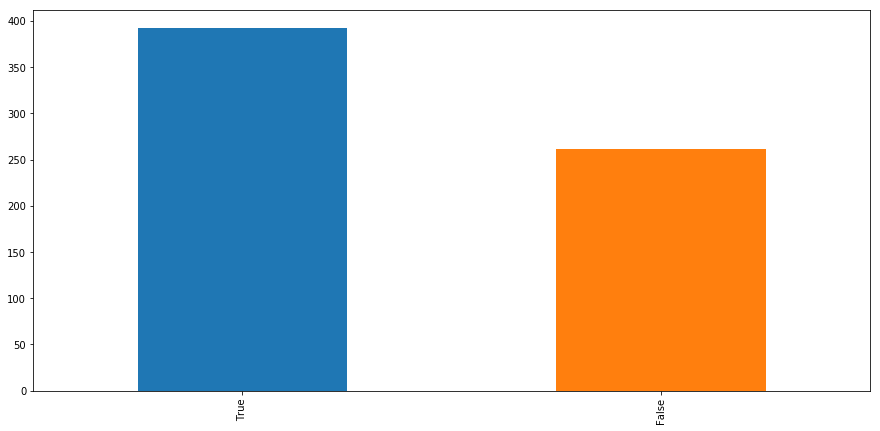

In [225]:
validation_df['Test4Match'] = data_list
validation_df['Test4Match'].value_counts().plot(kind='bar', figsize=(15,7))

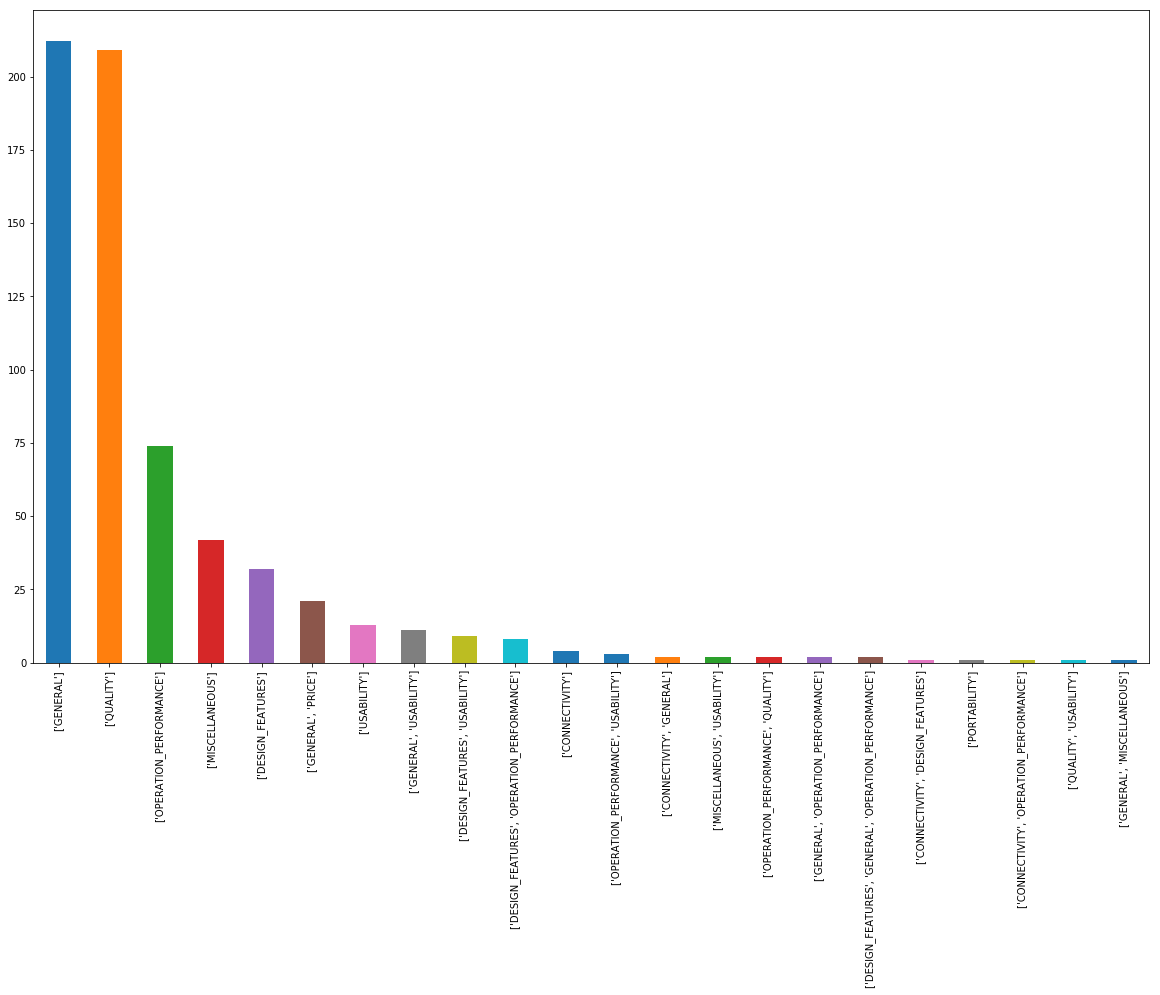

In [226]:
validation_df['predicted'].astype(str).value_counts().plot(kind='bar', figsize=(20,12))
#validation_df['actual'].astype(str).value_counts().plot(kind='bar', figsize=(20,12))

In [227]:
annotated_reviews_df.head(10)

,Unnamed: 0,ReviewText,aspects,terms,text_pro,aspect_first,aspect_second
0,0,This computer is absolutely AMAZING!!!,[LAPTOP#GENERAL],NaN,This computer is absolutely AMAZING!!!,[LAPTOP],[GENERAL]
1,1,10 plus hours of battery...,[BATTERY#OPERATION_PERFORMANCE],NaN,10 plus hours of battery...,[BATTERY],[OPERATION_PERFORMANCE]
2,2,super fast processor and really nice graphics ...,"[CPU#OPERATION_PERFORMANCE, GRAPHICS#GENERAL]",NaN,super fast processor and really nice graphics ...,"[CPU, GRAPHICS]","[OPERATION_PERFORMANCE, GENERAL]"
3,3,and plenty of storage with 250 gb(though I wil...,[HARD_DISC#DESIGN_FEATURES],NaN,and plenty of storage with 250 gb(though I wil...,[HARD_DISC],[DESIGN_FEATURES]
4,4,This computer is really fast and I'm shocked a...,"[LAPTOP#OPERATION_PERFORMANCE, LAPTOP#USABILITY]",NaN,This computer is really fast and I'm shocked a...,[LAPTOP],"[OPERATION_PERFORMANCE, USABILITY]"
5,5,I've only had mine a day but I'm already used ...,[LAPTOP#USABILITY],NaN,I've only had mine a day but I'm already used ...,[LAPTOP],[USABILITY]
6,6,GET THIS COMPUTER FOR PORTABILITY AND FAST PRO...,"[LAPTOP#PORTABILITY, CPU#OPERATION_PERFORMANCE]",NaN,GET THIS COMPUTER FOR PORTABILITY AND FAST PRO...,"[LAPTOP, CPU]","[PORTABILITY, OPERATION_PERFORMANCE]"
7,7,the laptop was really good and it goes really ...,"[LAPTOP#GENERAL, LAPTOP#OPERATION_PERFORMANCE]",NaN,the laptop was really good and the laptop goes...,[LAPTOP],"[OPERATION_PERFORMANCE, GENERAL]"
8,8,i would really recommend to any person out the...,[LAPTOP#GENERAL],NaN,i would really recommend to any person out the...,[LAPTOP],[GENERAL]
9,9,and its really cheap and you wont regret buyin...,"[LAPTOP#PRICE, LAPTOP#GENERAL]",NaN,and its really cheap and you wont regret buyin...,[LAPTOP],"[PRICE, GENERAL]"


In [229]:
validation_df.head(50)

,predicted,actual,ReviewText,Test4Match
0,[GENERAL],"[GENERAL, OPERATION_PERFORMANCE]",I've been using Apple's since 1992 and this is...,True
1,"[GENERAL, USABILITY]",[GENERAL],I love the operating system and the preloaded ...,False
2,[GENERAL],[GENERAL],Unimpressed.,True
3,[QUALITY],[GENERAL],This little netboook is helping me get work done!,False
4,[GENERAL],[OPERATION_PERFORMANCE],Also very quick laptop!,False
5,[MISCELLANEOUS],"[DESIGN_FEATURES, USABILITY]","However, the multi-touch gestures and large tr...",False
6,[GENERAL],[GENERAL],But the Macbook is the best!,True
7,[MISCELLANEOUS],[OPERATION_PERFORMANCE],It takes for ever to wake it up.,False
8,[OPERATION_PERFORMANCE],[QUALITY],The computer itself runs very quiet and is mos...,False
9,[OPERATION_PERFORMANCE],"[GENERAL, OPERATION_PERFORMANCE]",it was slow and might be problematic.,True
